# Data Cleaning

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [82]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("AlanYky/tweets_instruct_2", split="train")

In [9]:
df = dataset.to_pandas()
df

,instruction,text
0,Generate a tweet about FAMU.,School Monday and honestly I've always hated s...
1,Generate a tweet about dbh.,dbh the worst game of all time its awful its t...
2,Generate a tweet about Madrid.,I wish I had a @user cheki to do that wota thi...
3,Generate a tweet about Patronato.,"10’ | 0-0 | Good start, Patronato dangerous on..."
4,Generate a tweet about Torrey Pines.,I don't have a big opinion on the Torrey Pines...
...,...,...
200453,Can you write a tweet with a friendly tone?,You're eating skin that could have been sent t...
200454,Can you write a tweet with a controversial tone?,Very important thing for today: \n\nDo not #bu...
200455,Can you write a tweet with a controversial tone?,Which #chutiya #producer #invested in #crap #d...
200456,Can you write a tweet with a controversial tone?,Russia story will infuriate Trump today. Media...


In [12]:
# Print the Noise Signal
def print_detection(data):
    num_rows = len(data)
    print("Number of data: ", num_rows)
    print("-----")
    link_count = data['text'].str.contains(r"http\S+|www\.\S+", case=False).sum()
    mention_count = data['text'].str.contains(r"@\w+").sum()
    hashtag_count = data['text'].str.contains(r"#\w+").sum()
    long_text_count = data['text'].str.split().apply(len).gt(250).sum()

    multiple_mentions_count = data['text'].str.count(r"@\w+").gt(1).sum()
    multiple_hashtags_count = data['text'].str.count(r"#\w+").gt(2).sum()
    # low_quality_content_count = data['text'].str.contains("click", case=False).sum()
    low_quality_content_count = data['text'].str.contains(r"click|sale|subscribe|link in bio|RT", case=False).sum()

    print("link_count", link_count)
    print("mention_count", mention_count)
    print("hashtag_count", hashtag_count)
    print("long_text_count", long_text_count)
    print("Texts with more than 1 mention:", multiple_mentions_count)
    print("Texts with more than 2 hashtag:", multiple_hashtags_count)
    print("low_quality_content_count", low_quality_content_count)

# Remove the Link Data
# Delete rows containing links in the text column
def remove_links(dataframe):
    dataframe = dataframe[~dataframe['text'].str.contains(r"http\S+|www\.\S+", case=False, regex=True)]
    return dataframe

# Remove the Extreme Long Data
def remove_long_texts(dataframe, word_limit=250):
    return dataframe[~dataframe['text'].str.split().apply(len).gt(word_limit)]

# Remove the data have mentions @
def remove_mentions(dataframe):
    return dataframe[~dataframe['text'].str.contains(r"@\w+")]

# Remove the low quality data (with too advertisement text)
def remove_low_quality_content(dataframe):
    low_quality_pattern = r"click|subscribe|link in bio|RT"
    dataframe = dataframe[~dataframe['text'].str.contains(low_quality_pattern, case=False, regex=True)]
    return dataframe

In [13]:
print_detection(df)

Number of data:  200458
-----
link_count 3258
mention_count 930
hashtag_count 27195
long_text_count 0
Texts with more than 1 mention: 4
Texts with more than 2 hashtag: 5412
low_quality_content_count 28829


In [14]:
df = remove_links(df)
df = remove_long_texts(df)
df = remove_mentions(df)
df = remove_low_quality_content(df)

In [15]:
print_detection(df)

Number of data:  168881
-----
link_count 0
mention_count 0
hashtag_count 20225
long_text_count 0
Texts with more than 1 mention: 0
Texts with more than 2 hashtag: 3637
low_quality_content_count 425


# Benchmark Human Tweets POS and Constituent Distribution

In [116]:
import nltk
from nltk import pos_tag, word_tokenize, RegexpParser
from collections import Counter
from nltk.tree import Tree
from nltk.corpus import treebank
import re

In [30]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('treebank')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [31]:
# Define grammar for chunking
grammar = r"""
    NP: {<DT>?<JJ>*<NN.*>}    # Noun phrase
    VP: {<VB.*><NP|PP|CLAUSE>+$}  # Verb phrase
    PP: {<IN><NP>}              # Prepositional phrase
    ADJP: {<JJ><CC>*<JJ>*}      # Adjective phrase
    ADVP: {<RB.*>}              # Adverb phrase
"""

# Create a RegexpParser with the grammar
parser = RegexpParser(grammar)

## Main Pipeline

In [1]:
human_distribution_benchmark = {
    "NNP":0.11107245214850336,
    "CC":0.024262175839871215,
    "RB":0.05238026804527889,
    "PRP":0.05956264107107177,
    "VBP":0.0363054932074732,
    "VBN":0.011839412350151873,
    "NN":0.1409238945795302,
    "VB":0.04371257145342362,
    "DT":0.05979932216551541,
    "IN":0.07728031676817795,
    "CD":0.017169621871224054,
    "NNS":0.030351277605178115,
    ".":0.06337695703119336,
    "JJ":0.058788306252099715,
    "''":0.006478002525018547,
    ",":0.01874570995819159,
    "WDT":0.0016583434340378298,
    "VBZ":0.025435181210735677,
    "POS":0.003736787931848451,
    "TO":0.022256216896950124,
    "``":0.0035788954840238686,
    "PRP$":0.015399398558987169,
    "VBD":0.02242545490988785,
    "JJS":0.0018401876304346045,
    "VBG":0.021872358610622096,
    "MD":0.012826161360408895,
    "#":0.011843194205189587,
    "WRB":0.005464150220324571,
    "WP":0.0038455162641827445,
    "PDT":0.0007850500749122452,
    "RP":0.005637485242886488,
    "RBR":0.0009126876824351113,
    "JJR":0.002109644801871766,
    "$":0.000583035984980993,
    ":":0.0169212800570808,
    "(":0.002084432434953669,
    ")":0.0024471753639877898,
    "EX":0.0009987248845431172,
    "FW":0.00040875549865964755,
    "NNPS":0.0011373929025926507,
    "RBS":0.00027985727279087664,
    "UH":0.001336570601245617,
    "WP$":2.4897212331620784e-05,
    "SYM":9.265544842400646e-05,
    "LS":1.0084946767238798e-05,
    "NP":0.6919773154224048,
    "ADVP":0.1307694201308702,
    "ADJP":0.05708685343799667,
    "PP":0.11067809101217466,
    "VP":0.009488319996553618
}

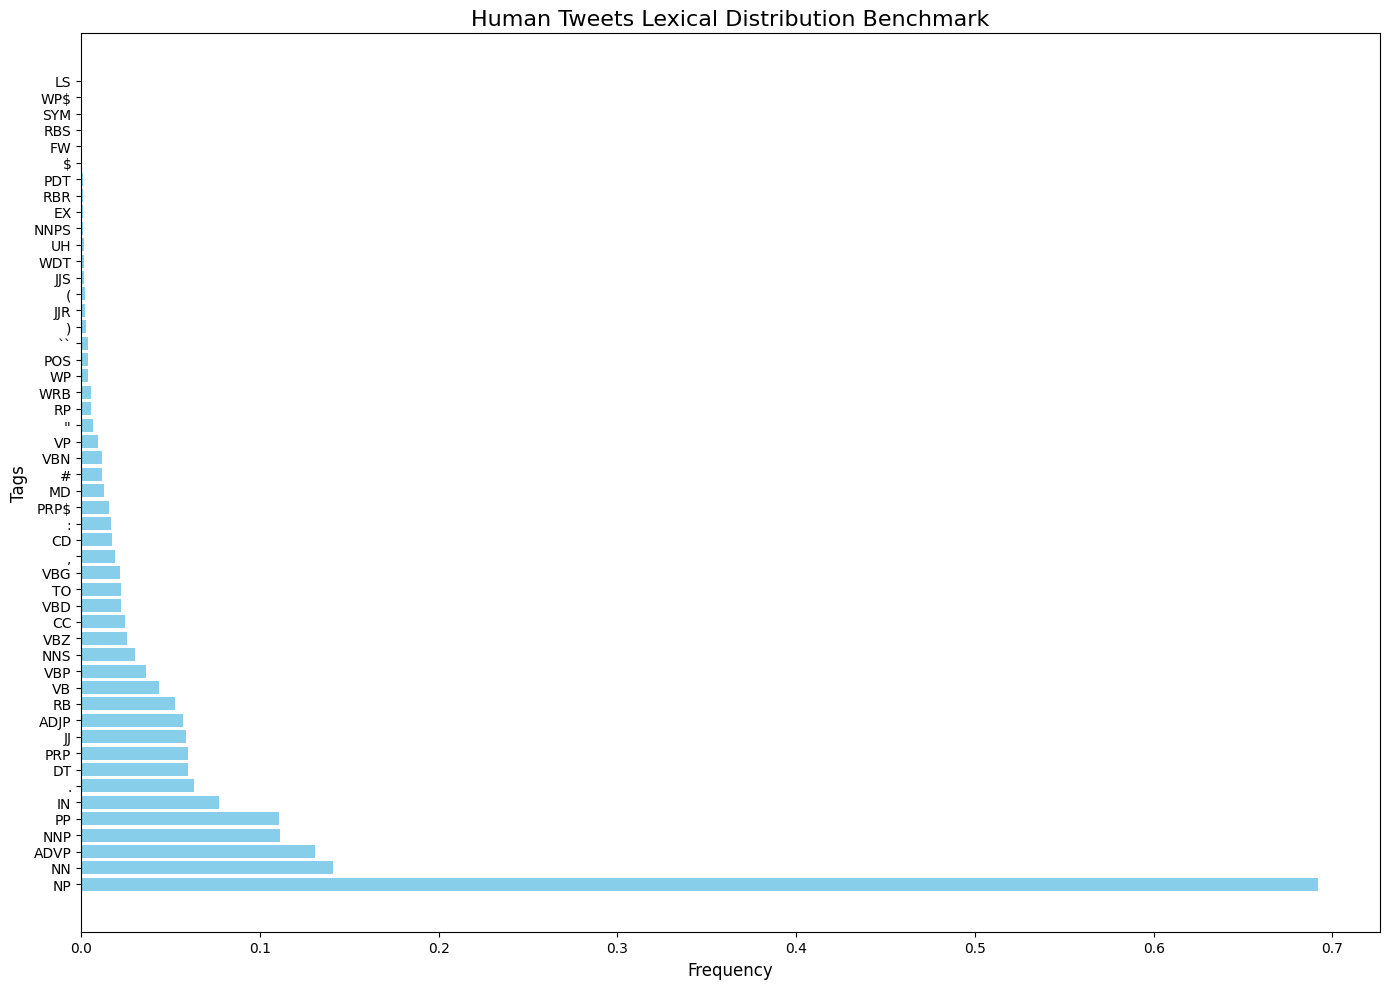

In [3]:
import matplotlib.pyplot as plt

# Sort data for better visualization
sorted_data = dict(sorted(human_distribution_benchmark.items(), key=lambda x: x[1], reverse=True))

# Extract keys and values
tags = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(14, 10))
plt.barh(tags, frequencies, color='skyblue')

plt.title("Human Tweets Lexical Distribution Benchmark", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Tags", fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [121]:
def calculate_distributions(texts):
    pos_counts = Counter()
    constituent_counts = Counter()
    total_tokens = 0
    total_constituents = 0

    for i, text in enumerate(texts, start=1):
        # Tokenize and POS tag
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)

        # Calculate POS distribution
        for _, tag in pos_tags:
            pos_counts[tag] += 1
            total_tokens += 1

        # Parse for constituent distribution
        parse_tree = parser.parse(pos_tags)
        for subtree in parse_tree.subtrees():
            if subtree.label() in {"NP", "VP", "PP", "ADJP", "ADVP"}:
                constituent_counts[subtree.label()] += 1
                total_constituents += 1

        # Print progress every 1000 texts
        if i % 1000 == 0:
            print(f"Finished processing {i} texts")

    # Convert counts to percentages
    pos_distribution = {pos: count / total_tokens for pos, count in pos_counts.items()}
    constituent_distribution = {constituent: count / total_constituents
                                for constituent, count in constituent_counts.items()}

    # Combine both distributions in one dictionary
    combined_distribution = {**pos_distribution, **constituent_distribution}

    return combined_distribution


def cosine_similarity(dist1, dist2):
    # Calculate cosine similarity between two distributions
    all_keys = set(dist1.keys()).union(dist2.keys())
    vec1 = [dist1.get(key, 0) for key in all_keys]
    vec2 = [dist2.get(key, 0) for key in all_keys]

    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    magnitude1 = math.sqrt(sum(a * a for a in vec1))
    magnitude2 = math.sqrt(sum(b * b for b in vec2))

    if magnitude1 == 0 or magnitude2 == 0:
        return 0  # Avoid division by zero
    return dot_product / (magnitude1 * magnitude2)


def remove_words_with_ampersand(input_text):
    # Split the text into words
    words = input_text.split()
    # Filter out words containing '&'
    filtered_words = [word for word in words if '&' not in word]
    # Join the remaining words back into a string
    return ' '.join(filtered_words)

def clean_tweet(tweet):
    # Remove trailing sequences of non-ASCII characters (like `����������������`)
    cleaned_tweet = re.sub(r"[^\x00-\x7F]+$", "", tweet)

    # change more than one dot to one dot
    cleaned_tweet = re.sub(r"\.{2,}", ".", cleaned_tweet)

    # change more than two question marks to two question marks
    cleaned_tweet = re.sub(r"\?{3,}", "??", cleaned_tweet)

    # change more than two ! to two !
    cleaned_tweet = re.sub(r"!{3,}", "!!", cleaned_tweet)

    # remove the word including &
    cleaned_tweet = remove_words_with_ampersand(cleaned_tweet)

    return cleaned_tweet.strip()

def most_human_like_tweet(generated_tweets, benchmark):
    best_score = -1
    best_tweet = None

    for tweet in generated_tweets:
        # Calculate the distribution for the generated tweet
        cleaned_tweet = clean_tweet(tweet)
        tweet_distribution = calculate_distributions([cleaned_tweet])

        # Calculate similarity with the benchmark
        score = cosine_similarity(tweet_distribution, benchmark)

        print(f"Tweet: {cleaned_tweet}")
        print(f"Human-likeness Score: {score:.4f}")

        # Check if this is the highest score
        if score > best_score:
            best_score = score
            best_tweet = cleaned_tweet

    return best_tweet

In [86]:
# Extract the 'text' column and select only the first 10 tweets
human_tweets = dataset["text"]

# Calculate POS and constituent type distributions for the first 10 human tweets
distribution = calculate_distributions(human_tweets)

Finished processing 1000 texts
Finished processing 2000 texts
Finished processing 3000 texts
Finished processing 4000 texts
Finished processing 5000 texts
Finished processing 6000 texts
Finished processing 7000 texts
Finished processing 8000 texts
Finished processing 9000 texts
Finished processing 10000 texts
Finished processing 11000 texts
Finished processing 12000 texts
Finished processing 13000 texts
Finished processing 14000 texts
Finished processing 15000 texts
Finished processing 16000 texts
Finished processing 17000 texts
Finished processing 18000 texts
Finished processing 19000 texts
Finished processing 20000 texts
Finished processing 21000 texts
Finished processing 22000 texts
Finished processing 23000 texts
Finished processing 24000 texts
Finished processing 25000 texts
Finished processing 26000 texts
Finished processing 27000 texts
Finished processing 28000 texts
Finished processing 29000 texts
Finished processing 30000 texts
Finished processing 31000 texts
Finished processi

In [34]:
# Display the distributions
print("Lexical Distribution for the Human Tweets:")
print(distribution)

Lexical Distribution for the Human Tweets:
{'POS_Distribution': {'NNP': 0.11107245214850336, 'CC': 0.024262175839871215, 'RB': 0.05238026804527889, 'PRP': 0.05956264107107177, 'VBP': 0.0363054932074732, 'VBN': 0.011839412350151873, 'NN': 0.1409238945795302, 'VB': 0.04371257145342362, 'DT': 0.05979932216551541, 'IN': 0.07728031676817795, 'CD': 0.017169621871224054, 'NNS': 0.030351277605178115, '.': 0.06337695703119336, 'JJ': 0.058788306252099715, "''": 0.006478002525018547, ',': 0.01874570995819159, 'WDT': 0.0016583434340378298, 'VBZ': 0.025435181210735677, 'POS': 0.003736787931848451, 'TO': 0.022256216896950124, '``': 0.0035788954840238686, 'PRP$': 0.015399398558987169, 'VBD': 0.02242545490988785, 'JJS': 0.0018401876304346045, 'VBG': 0.021872358610622096, 'MD': 0.012826161360408895, '#': 0.011843194205189587, 'WRB': 0.005464150220324571, 'WP': 0.0038455162641827445, 'PDT': 0.0007850500749122452, 'RP': 0.005637485242886488, 'RBR': 0.0009126876824351113, 'JJR': 0.002109644801871766, '$':

In [87]:
# Display the distributions
print("Lexical Distribution for the Human Tweets:")
print(distribution)

Lexical Distribution for the Human Tweets:
{'NNP': 0.11784279716897358, 'CC': 0.024218400664049265, 'RB': 0.05018358342244844, 'PRP': 0.056776967869437235, 'VBP': 0.03452376004040725, 'VBN': 0.011762690558332924, 'NN': 0.14094017384688828, 'VB': 0.04239662332460446, 'DT': 0.060314617271074934, 'IN': 0.07831549141786862, 'CD': 0.01759075570872018, 'NNS': 0.030624108061673955, '.': 0.06126383488450304, 'JJ': 0.05860965315014038, "''": 0.006541993684478352, ',': 0.01911081385081816, 'WDT': 0.0016926202613119507, 'VBZ': 0.02524848315378056, 'POS': 0.00376336569187963, 'TO': 0.022043614130948196, '``': 0.003658065011833731, 'PRP$': 0.015349715398461049, 'VBD': 0.02209576063996614, 'JJS': 0.0018689611130634563, 'WRB': 0.005254705466692362, 'MD': 0.012410617230768455, '#': 0.013422561804319595, 'VBG': 0.02162694588980964, 'WP': 0.0037767172135122437, 'PDT': 0.000785472536801706, 'RP': 0.005473116207361727, 'RBR': 0.0009023613299627039, 'EX': 0.000996325812396006, '(': 0.002306538340909692, ')

# Post-Processing Human-like Tweet Selection based on lexical distribution

In [64]:
import math

In [65]:
human_distribution_benchmark = {
   "NNP":0.11107245214850336,
   "CC":0.024262175839871215,
   "RB":0.05238026804527889,
   "PRP":0.05956264107107177,
   "VBP":0.0363054932074732,
   "VBN":0.011839412350151873,
   "NN":0.1409238945795302,
   "VB":0.04371257145342362,
   "DT":0.05979932216551541,
   "IN":0.07728031676817795,
   "CD":0.017169621871224054,
   "NNS":0.030351277605178115,
   ".":0.06337695703119336,
   "JJ":0.058788306252099715,
   "''":0.006478002525018547,
   ",":0.01874570995819159,
   "WDT":0.0016583434340378298,
   "VBZ":0.025435181210735677,
   "POS":0.003736787931848451,
   "TO":0.022256216896950124,
   "``":0.0035788954840238686,
   "PRP$":0.015399398558987169,
   "VBD":0.02242545490988785,
   "JJS":0.0018401876304346045,
   "VBG":0.021872358610622096,
   "MD":0.012826161360408895,
   "#":0.011843194205189587,
   "WRB":0.005464150220324571,
   "WP":0.0038455162641827445,
   "PDT":0.0007850500749122452,
   "RP":0.005637485242886488,
   "RBR":0.0009126876824351113,
   "JJR":0.002109644801871766,
   "$":0.000583035984980993,
   ":":0.0169212800570808,
   "(":0.002084432434953669,
   ")":0.0024471753639877898,
   "EX":0.0009987248845431172,
   "FW":0.00040875549865964755,
   "NNPS":0.0011373929025926507,
   "RBS":0.00027985727279087664,
   "UH":0.001336570601245617,
   "WP$":2.4897212331620784e-05,
   "SYM":9.265544842400646e-05,
   "LS":1.0084946767238798e-05,
   "NP":0.6919773154224048,
   "ADVP":0.1307694201308702,
   "ADJP":0.05708685343799667,
   "PP":0.11067809101217466,
   "VP":0.009488319996553618
}

In [127]:
generated_tweets = [
    "I don’t know how many times people have told me “ChatGPT is going to take over the world” and now it seems like they were right. #chatgptiscontrollingus 😭😂🤣💀❗️#fuckyouallofu",
    "I'm not sure if this was an accident or intentional but the last few days have been filled with people saying that ChatGpt and other AI are taking over. It seems like it has become more of our reality than we thought possible.. #TheMatrixRebornIsReal 🤯❓",
    "I'm not sure if it was the Chaos or something else, but there were some really weird things happening to me lately. It felt like my brain had been hacked and someone took control of what i thought/felt - especially when writing this article for example: https://tapas-hubbard",
]

In [128]:
most_human_like_tweet(
    generated_tweets=generated_tweets,
    benchmark=human_distribution_benchmark
)

Tweet: I don’t know how many times people have told me “ChatGPT is going to take over the world” and now it seems like they were right. #chatgptiscontrollingus 😭😂🤣💀❗️#fuckyouallofu
Human-likeness Score: 0.9681
Tweet: I'm not sure if this was an accident or intentional but the last few days have been filled with people saying that ChatGpt and other AI are taking over. It seems like it has become more of our reality than we thought possible.. #TheMatrixRebornIsReal
Human-likeness Score: 0.9163
Tweet: I'm not sure if it was the Chaos or something else, but there were some really weird things happening to me lately. It felt like my brain had been hacked and someone took control of what i thought/felt - especially when writing this article for example: https://tapas-hubbard
Human-likeness Score: 0.9327


'I don’t know how many times people have told me “ChatGPT is going to take over the world” and now it seems like they were right. #chatgptiscontrollingus 😭😂🤣💀❗️#fuckyouallofu'

In [88]:
# ex = {
#    "NNP":0.11784279716897358,
#    "CC":0.024218400664049265,
#    "RB":0.05018358342244844,
#    "PRP":0.056776967869437235,
#    "VBP":0.03452376004040725,
#    "VBN":0.011762690558332924,
#    "NN":0.14094017384688828,
#    "VB":0.04239662332460446,
#    "DT":0.060314617271074934,
#    "IN":0.07831549141786862,
#    "CD":0.01759075570872018,
#    "NNS":0.030624108061673955,
#    ".":0.06126383488450304,
#    "JJ":0.05860965315014038,
#    "''":0.006541993684478352,
#    ",":0.01911081385081816,
#    "WDT":0.0016926202613119507,
#    "VBZ":0.02524848315378056,
#    "POS":0.00376336569187963,
#    "TO":0.022043614130948196,
#    "``":0.003658065011833731,
#    "PRP$":0.015349715398461049,
#    "VBD":0.02209576063996614,
#    "JJS":0.0018689611130634563,
#    "WRB":0.005254705466692362,
#    "MD":0.012410617230768455,
#    "#":0.013422561804319595,
#    "VBG":0.02162694588980964,
#    "WP":0.0037767172135122437,
#    "PDT":0.000785472536801706,
#    "RP":0.005473116207361727,
#    "RBR":0.0009023613299627039,
#    "EX":0.000996325812396006,
#    "(":0.002306538340909692,
#    ")":0.002655693227377673,
#    ":":0.017687491261681006,
#    "JJR":0.0020518517678800178,
#    "$":0.0006375981368329435,
#    "FW":0.00042221038219360463,
#    "SYM":9.421639793580438e-05,
#    "NNPS":0.0012192710321104095,
#    "RBS":0.0003020466875000787,
#    "UH":0.001199873538417744,
#    "WP$":2.8718367285245185e-05,
#    "LS":8.817042587575275e-06,
#    "NP":0.7006743969661854,
#    "ADVP":0.12389189727593185,
#    "ADJP":0.05483301629873648,
#    "PP":0.11205776103122488,
#    "VP":0.008542928427921394
# }